# Downloading Kaggle dataset

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# downloading dataset from kaggle
!kaggle competitions download -c dogs-vs-cats

 99% 804M/812M [00:03<00:00, 296MB/s]
100% 812M/812M [00:03<00:00, 254MB/s]


In [4]:
!ls

dogs-vs-cats.zip  kaggle.json  sample_data


In [5]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [6]:
!ls

dogs-vs-cats.zip  sample_data		test1.zip
kaggle.json	  sampleSubmission.csv	train.zip


# Copying images to training, validation, and test directories

In [16]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("dogs_vs_cats_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst= dir / fname)

In [17]:
make_subset("train", start_index=0, end_index=1_000)
make_subset("validation", start_index=1_000, end_index=1_500)
make_subset("test", start_index=1_500, end_index=2_500)

In [23]:
!ls dogs_vs_cats_small/

test  train  validation


# Build model

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Rescaling

inputs = Input(shape=(180, 180, 3))
x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [25]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Generate tensorflow dataset

In [26]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [27]:
for data_batch, labels_batch in train_dataset:
    print(f"data batch shape: {data_batch.shape}")
    print(f"labels batch shape: {labels_batch.shape}")
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


# Fit the model

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [31]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - 19s 85ms/step - loss: 0.7878 - accuracy: 0.5095 - val_loss: 0.6886 - val_accuracy: 0.5680
Epoch 2/30
63/63 [==============================] - 5s 73ms/step - loss: 0.7075 - accuracy: 0.5175 - val_loss: 0.6819 - val_accuracy: 0.6230
Epoch 3/30
63/63 [==============================] - 5s 72ms/step - loss: 0.7389 - accuracy: 0.6095 - val_loss: 0.6696 - val_accuracy: 0.6060
Epoch 4/30
63/63 [==============================] - 5s 71ms/step - loss: 0.6524 - accuracy: 0.6560 - val_loss: 0.6319 - val_accuracy: 0.6220
Epoch 5/30
63/63 [==============================] - 5s 71ms/step - loss: 0.6041 - accuracy: 0.6655 - val_loss: 0.6604 - val_accuracy: 0.6490
Epoch 6/30
63/63 [==============================] - 5s 73ms/step - loss: 0.5893 - accuracy: 0.6940 - val_loss: 0.5891 - val_accuracy: 0.6720
Epoch 7/30
63/63 [==============================] - 5s 72ms/step - loss: 0.5405 - accuracy: 0.7315 - val_loss: 0.5875 - val_accuracy: 0.6950
Epoch 8/30
6

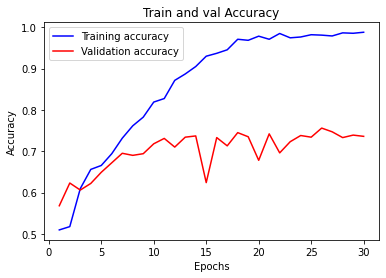

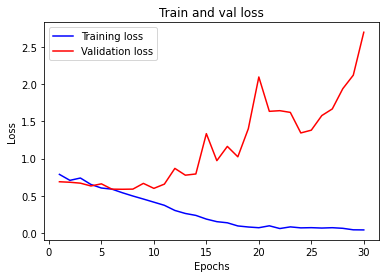

In [34]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
acc = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_acc = history.history["val_accuracy"]
x_range = range(1, len(loss) +1)

plt.plot(x_range, acc, "b", label="Training accuracy")
plt.plot(x_range, val_acc, "r", label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and val Accuracy")
plt.legend()
plt.figure()
plt.plot(x_range, loss, "b", label="Training loss")
plt.plot(x_range, val_loss, "r", label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and val loss")
plt.legend()
plt.show()

In [35]:
from tensorflow.keras.models import load_model

test_model = load_model("convnet_from_scratch.keras")

test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"test accuracy: {test_acc}")

63/63 [==============================] - 3s 39ms/step - loss: 0.5816 - accuracy: 0.7010
test accuracy: 0.7009999752044678
